In [ ]:
!pip install scikit-learn==1.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 60.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.0.2 which is incompatible.


In [ ]:
# Import necessary libraries
import joblib
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import LabelEncoder

# Mount Google Drive
drive.mount('/content/drive')

# Step 1: Load saved SHAP values, X_test, and y_test
load_dir = '/content/drive/My Drive/SHAP_saved_NF_BoT_IoT_V2'
shap_values = joblib.load(f"{load_dir}/shap_values.pkl")
X_test = joblib.load(f"{load_dir}/X_test.pkl")
y_test = joblib.load(f"{load_dir}/y_test.pkl")

le = LabelEncoder()
y_test = le.fit_transform(y_test)

# Step 2: Calculate feature importance based on SHAP values and class weights
if isinstance(shap_values, list):  # Multi-class SHAP values
    num_classes = len(shap_values)
    class_sizes = pd.Series(y_test).value_counts().sort_index().values  # Size of each class
    feature_importance = np.zeros(X_test.shape[1])

    for class_index in range(num_classes):
        shap_values_class = shap_values[class_index]
        # Calculate mean absolute SHAP values for each feature
        mean_shap_per_feature = np.abs(shap_values_class).mean(axis=0)
        # Weight feature importance by class size
        feature_importance += mean_shap_per_feature * class_sizes[class_index]
else:
    # For binary classification
    feature_importance = np.abs(shap_values).mean(axis=0)

Mounted at /content/drive


In [ ]:
feature_importance.shape

(40, 5)

In [ ]:
# Step 3: Sort features by importance and select top 10
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': feature_importance[:,0]  # Select the first column of the feature_importance array
}).sort_values(by='Importance', ascending=False)

top_10_features = feature_importance_df.head(10)['Feature'].values
print("Top 10 Features:", top_10_features)

Top 10 Features: ['FLOW_DURATION_MILLISECONDS' 'CLIENT_TCP_FLAGS' 'IN_BYTES' 'L4_DST_PORT'
 'TCP_FLAGS' 'SHORTEST_FLOW_PKT' 'DURATION_IN' 'IN_PKTS' 'OUT_BYTES'
 'SRC_TO_DST_SECOND_BYTES']


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import time

# Step 4: Filter dataset to include only the top 10 features
X_test_filtered = X_test[top_10_features]

# Optional: Save the filtered dataset for further use
joblib.dump(X_test_filtered, f"{load_dir}/X_test_filtered.pkl")
joblib.dump(top_10_features, f"{load_dir}/top_10_features.pkl")

# Step 5: Define parameter grid for GridSearch
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'scale_pos_weight': [1, 3]
}

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(random_state=42,use_label_encoder=True, eval_metric='logloss')

# Step 6: Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='recall_weighted',  # Use Recall_weighted for multi-class classification
    cv=5,
    verbose=3
)

# ------------------------------------------ Train Time---------------------------------------------

# Start time for training
start_time = time.time()

grid_search.fit(X_test_filtered, y_test)

# End time for training
end_time = time.time()

# Calculate execution time for training
training_execution_time = end_time - start_time
print('**************************************************************************************')
print(f"Training execution time for XGBoost classifier: {training_execution_time:.5f} seconds")

#---------------------------------------------------------------------------------------------------

# Step 7:
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test_filtered)

print("\nBest Parameters from GridSearch:")
print(grid_search.best_params_)

print("\nClassification Report for Optimized Model:")
print(classification_report(y_test, y_pred))




Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=50, scale_pos_weight=1;, score=0.986 total time=   0.1s
[CV 2/5] END learning_rate=0.05, max_depth=3, n_estimators=50, scale_pos_weight=1;, score=0.975 total time=   0.1s
[CV 3/5] END learning_rate=0.05, max_depth=3, n_estimators=50, scale_pos_weight=1;, score=0.978 total time=   0.1s
[CV 4/5] END learning_rate=0.05, max_depth=3, n_estimators=50, scale_pos_weight=1;, score=0.948 total time=   0.1s
[CV 5/5] END learning_rate=0.05, max_depth=3, n_estimators=50, scale_pos_weight=1;, score=0.970 total time=   0.5s
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=50, scale_pos_weight=3;, score=0.986 total time=   0.1s
[CV 2/5] END learning_rate=0.05, max_depth=3, n_estimators=50, scale_pos_weight=3;, score=0.975 total time=   0.1s
[CV 3/5] END learning_rate=0.05, max_depth=3, n_estimators=50, scale_pos_weight=3;, score=0.978 total time=   0.1s
[CV 4/5] END learni

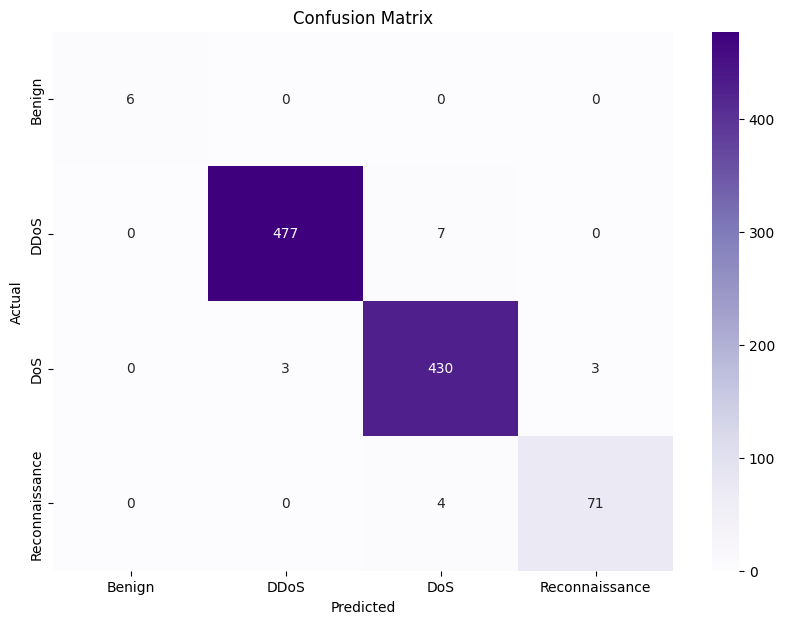

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 8: Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_) # Replace label_encoder with le
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score
# Calculate Recall (Weighted)
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall (weighted) on test data:", recall)

Recall (weighted) on test data: 0.983016983016983


In [ ]:
import time

# Start time
start_time = time.time()



# Make predictions using the best iteration
y_pred_xgboost =best_xgb_model.predict(X_test_filtered)

# End time
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time
print(f"Execution time for XGBoost classifier: {execution_time:.5f} seconds")

Execution time for XGBoost classifier: 0.00655 seconds


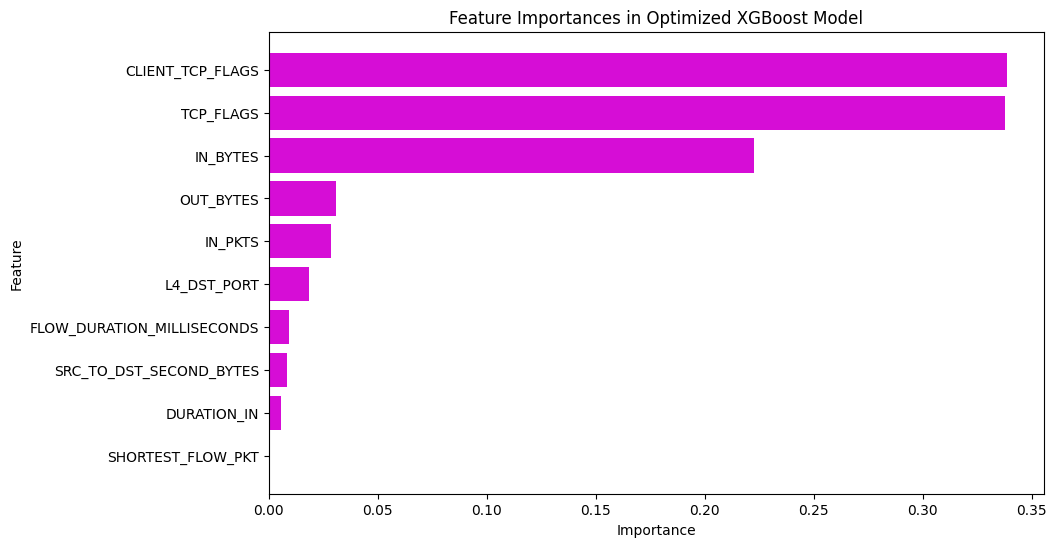

In [ ]:
# Step 8: Plot feature importances of the optimized model
optimized_feature_importances = pd.DataFrame({
    'Feature': top_10_features,
    'Importance': best_xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(optimized_feature_importances['Feature'], optimized_feature_importances['Importance'], color='#d60dd6')
plt.gca().invert_yaxis()
plt.title("Feature Importances in Optimized XGBoost Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()